# Examine some of the results for ReFrame compounds

Here we will look at ReFrame compounds and the diseases they're predicted to treat. For this, we will only use the subset of diseases with no known treatments within the network.

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '15_Final_Model_Training'

nw_dir = load_dir.joinpath('12d_Preprocessing-Abbreviations_and_Biolink', 'out')
hyp_dir = load_dir.joinpath('13c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

In [3]:
this_name = '16d_Model_results_analysis_Reframe_neg'
out_dir = load_dir.joinpath(this_name, 'out')

out_dir.mkdir(exist_ok=True, parents=True)

### Load and process the network

In [4]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [5]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [6]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:56<00:00,  1.21it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:34<00:00,  1.97it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 129.87it/s]


### Get relevent elements of model

In [7]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
len(res)

90996724

In [9]:
metapaths = coef.query('feature != "intercept"')['feature'].tolist()

In [10]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [11]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

res.head(2)

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
0,CHEBI:53769,MONDO:0005399,0,0.997371,(S)-acenocoumarol,venous thromboembolism
1,CHEBI:50438,MONDO:0005399,0,0.997320,phenprocoumon,venous thromboembolism


In [12]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [13]:
msat = model[0]
max_abs = model[1]

In [14]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

### Definie routines for extracting and weighting paths

In [15]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [16]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [17]:
def get_path_info(compound, disease, n_jobs=30):
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, pos_coef, n_jobs=n_jobs))
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    
    return path_df

In [18]:
ref_c = nodes[~nodes['source'].isnull()]['id'].unique()
len(ref_c)

5970

#### Subset diseases to those not treated

In [19]:
all_dis = nodes.query('label == "Disease"')['id'].unique()
treat_disease = edges.query('type == "treats_CtD"')['end_id'].unique()

utreat_dis = list(set(all_dis) - set(treat_disease))

len(utreat_dis)

8333

### Get probabilities from model for ReFrame - Disease pairs

In [20]:
(ref_pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=metapaths, start_nodes=ref_c, 
                                        end_nodes=list(utreat_dis), n_jobs=30, return_sparse=True, sparse_df=False)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 156/156 [03:39<00:00,  1.40s/it]



Reshaping Result Matrices...


100%|██████████| 156/156 [00:35<00:00,  4.34it/s]


Stacking columns...


In [21]:
ref_pairs['proba'] = model.predict_proba(dwpc)[:, 1]

In [22]:
ref_pairs['chem_name'] = ref_pairs['chemicalsubstance_id'].map(id_to_name)
ref_pairs['dis_name'] = ref_pairs['disease_id'].map(id_to_name)

In [23]:
pos_tups = set(edges.query('type == "treats_CtD"')[['start_id', 'end_id']].apply(tuple, axis=1))

In [24]:
status = []
for row in ref_pairs.itertuples():
    tup = (row.chemicalsubstance_id, row.disease_id)
    status.append(int(bool(pos_tups & {tup})))

In [25]:
ref_pairs['status'] = status
ref_pairs.sample(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
40575330,IKEY:MXDSJQHFFDGFDK-CYBMUJFWSA-N,DOID:0110052,0.006323,AZD-3759,amelogenesis imperfecta type 1B,0
39064087,IKEY:KSHMINBVGAHXNS-PXYKVGKMSA-L,MONDO:0013806,0.005566,Magnesium L-lactate dihydrate,familial cutaneous telangiectasia and orophary...,0
10266523,CHEBI:31257,DOID:0050600,0.002919,bendazac,ABCD syndrome,0
29275516,CHEBI:9207,DOID:0080501,0.014845,sotalol hydrochloride,GM1 gangliosidosis type 2,0
25473397,CHEBI:78652,OMIM:612560,0.005682,1-octadecyl-2-methylglycero-3-phosphocholine,BONE MINERAL DENSITY QUANTITATIVE TRAIT LOCUS 12,0
25532382,CHEBI:78887,DOID:0050098,0.005229,tirapazamine,obsolete Microsporum audouinii tinea capitis,0
33207087,IKEY:BLTVBQXJFVRPFK-UHFFFAOYSA-N,DOID:0050111,0.005413,Azd-1080,obsolete Microsporum fulvum tinea capitis,0
36804651,IKEY:HVASDHJNLYRZEA-UHFFFAOYSA-I,MESH:C562704,0.005413,Pentetate zinc trisodium,"Isolated Growth Hormone Deficiency, Type II",0
24748963,CHEBI:76277,WD:Q53951712,0.005413,tepoxalin,hard palate mucoepidermoid carcinoma,0
39094764,IKEY:KSPYMJJKQMWWNB-UHFFFAOYSA-N,DOID:4305,0.003964,Cipamfylline,bone giant cell tumor,0


### Save out results

In [26]:
ref_pairs.to_csv(out_dir.joinpath('reframe_probas.csv'), index=False)

In [27]:
ref_pairs = ref_pairs.sort_values('proba', ascending=False)

In [28]:
ref_pairs = ref_pairs.reset_index(drop=True)

In [29]:
%matplotlib inline

### Plot a few example paths

In [30]:
# Choose custom node colors
node_color_map = {'AnatomicalEntity': "#8c88d7",
                'BiologicalProcessOrActivity': "#b75970",
                'MacromolecularMachine': "#e71761",
                'Disease': "#70c6ca",
                'Pathway': "#b1d34f",
                'PhenotypicFeature': "#154e56",
                'GeneFamily': "#5a3386",
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': "#e9bf98",
                'ChemicalSubstance': "#01c472",}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()
id_to_label = nodes.set_index('id')['label'].to_dict()

edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

import graph_plots as gp

def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None, sort=True):


    if sort:
        top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)
    else:
        top_n_paths = path_df.head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))

   
    if type(poi_idx) == list:
        ec = []
        for idx in poi_idx:
            poi = path_df.loc[idx, 'node_ids']
            ec.append(gp.highlight_path_of_interest(list_of_paths, poi))
        
        # Take the edges from the first highlighted poi
        edge_color_map = ec[0]
        for ecm in ec[1:]:
            for k, v in ecm.items():
                # Any other highlihted paths get marked
                # seaborn 1 is highlight color.
                if v == sns.color_palette().as_hex()[1]:
                    edge_color_map[k] = v
        
    elif poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    else:
        path_of_interest = []
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    
    

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map, min_dist=3)

    return gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, node_names=None, proba=proba, n_paths=10, xscale=17);

In [31]:
# networkx throws LOTS of matplotlib warnings when plotting, so we're silencing
import warnings
warnings.simplefilter('ignore')

In [32]:
ref_pairs.query('status == 0').head(50)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,CHEBI:49105,DOID:0050659,0.574642,thiamine hydrochloride,biotin-responsive basal ganglia disease,0
1,CHEBI:16586,DOID:0111592,0.486447,6-aminohexanoic acid,plasminogen deficiency type I,0
2,CHEBI:15367,DOID:0110323,0.425395,all-trans-retinoic acid,hypertrophic cardiomyopathy 17,0
3,CHEBI:17823,DOID:0060896,0.420092,calcitriol,Parkinson's disease 23,0
4,CHEBI:53795,DOID:0070268,0.419263,(R)-amlodipine,congenital disorder of glycosylation type IIp,0
5,CHEBI:33216,DOID:0111667,0.413385,bisphenol A,enterokinase deficiency,0
6,CHEBI:29081,DOID:0070268,0.411624,synephrine,congenital disorder of glycosylation type IIp,0
7,CHEBI:33216,DOID:0050754,0.396758,bisphenol A,ataxia with oculomotor apraxia type 1,0
8,CHEBI:39427,DOID:0080626,0.395868,perfluorohexane,corticosterone methyloxidase deficiency 1,0
9,CHEBI:45906,DOID:0060679,0.394386,suramin,catecholaminergic polymorphic ventricular tach...,0


### Load a subset of Rare Diseases for examination

In [33]:
rare_dis = pd.read_csv('../0_data/manual/rare_disease_ids.txt', header=None)[0].tolist()

In [34]:
ref_pairs.query('disease_id in @rare_dis').head(50)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,CHEBI:49105,DOID:0050659,0.574642,thiamine hydrochloride,biotin-responsive basal ganglia disease,0
2,CHEBI:15367,DOID:0110323,0.425395,all-trans-retinoic acid,hypertrophic cardiomyopathy 17,0
4,CHEBI:53795,DOID:0070268,0.419263,(R)-amlodipine,congenital disorder of glycosylation type IIp,0
6,CHEBI:29081,DOID:0070268,0.411624,synephrine,congenital disorder of glycosylation type IIp,0
7,CHEBI:33216,DOID:0050754,0.396758,bisphenol A,ataxia with oculomotor apraxia type 1,0
9,CHEBI:45906,DOID:0060679,0.394386,suramin,catecholaminergic polymorphic ventricular tach...,0
10,CHEBI:16469,DOID:0070268,0.393978,17beta-estradiol,congenital disorder of glycosylation type IIp,0
19,CHEBI:23414,DOID:0070268,0.378217,copper(II) sulfate,congenital disorder of glycosylation type IIp,0
25,CHEBI:39867,DOID:0050983,0.374133,valproic acid,spinocerebellar ataxia type 36,0
30,CHEBI:4031,DOID:0070157,0.369587,cyclosporin A,hereditary sensory and autonomic neuropathy ty...,0


In [35]:
def plot_idx(test_idx, njob=30):

    cid = ref_pairs.loc[test_idx, 'chemicalsubstance_id']
    did = ref_pairs.loc[test_idx, 'disease_id']
    prob = ref_pairs.loc[test_idx, 'proba']

    print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
    path_df = get_path_info(cid, did, njob)

    draw_top_paths(path_df, 10, proba=prob)

Extracting data for: thiamine hydrochloride -TREATS- biotin-responsive basal ganglia disease


100%|██████████| 89/89 [00:00<00:00, 101.16it/s]


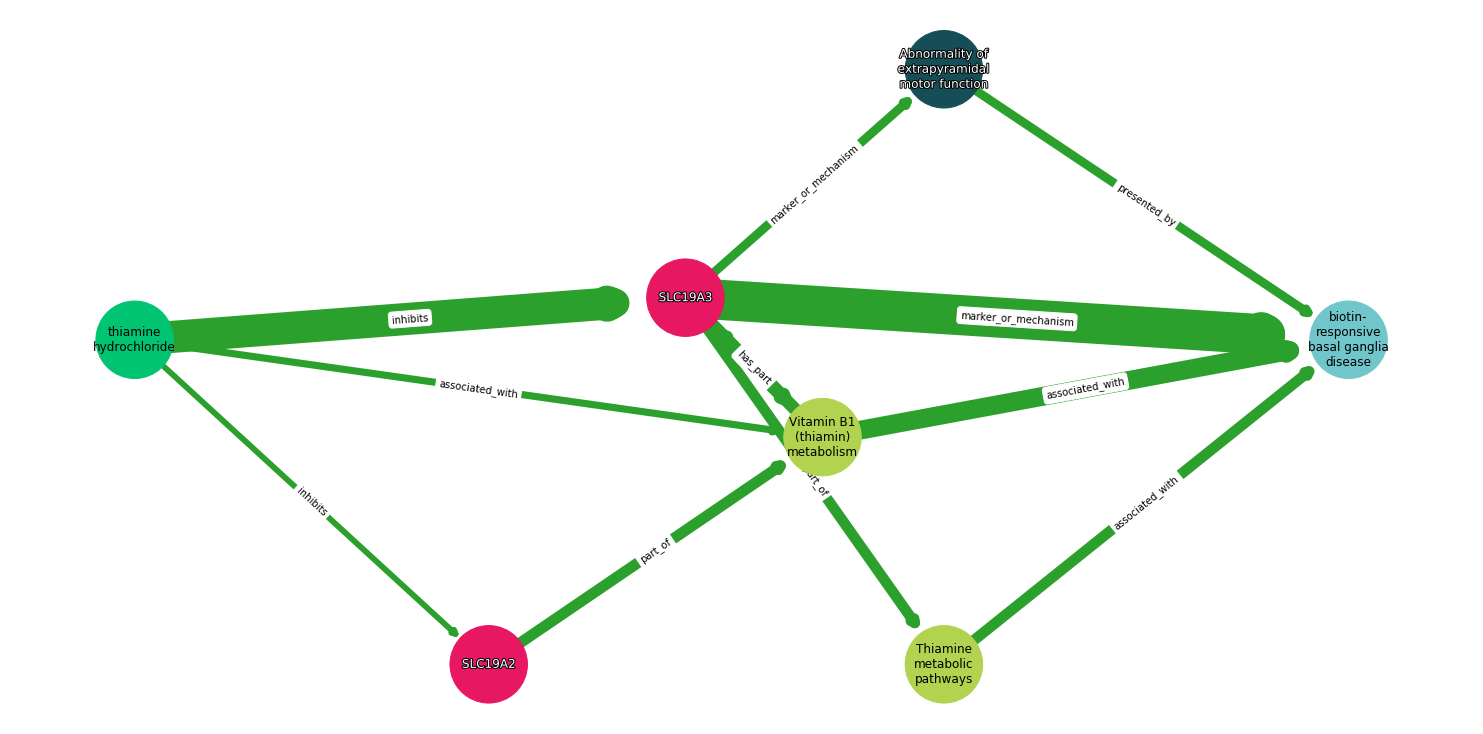

In [40]:
plot_idx(0)

Extracting data for: (R)-amlodipine -TREATS- congenital disorder of glycosylation type IIp


100%|██████████| 89/89 [01:12<00:00,  1.22it/s]


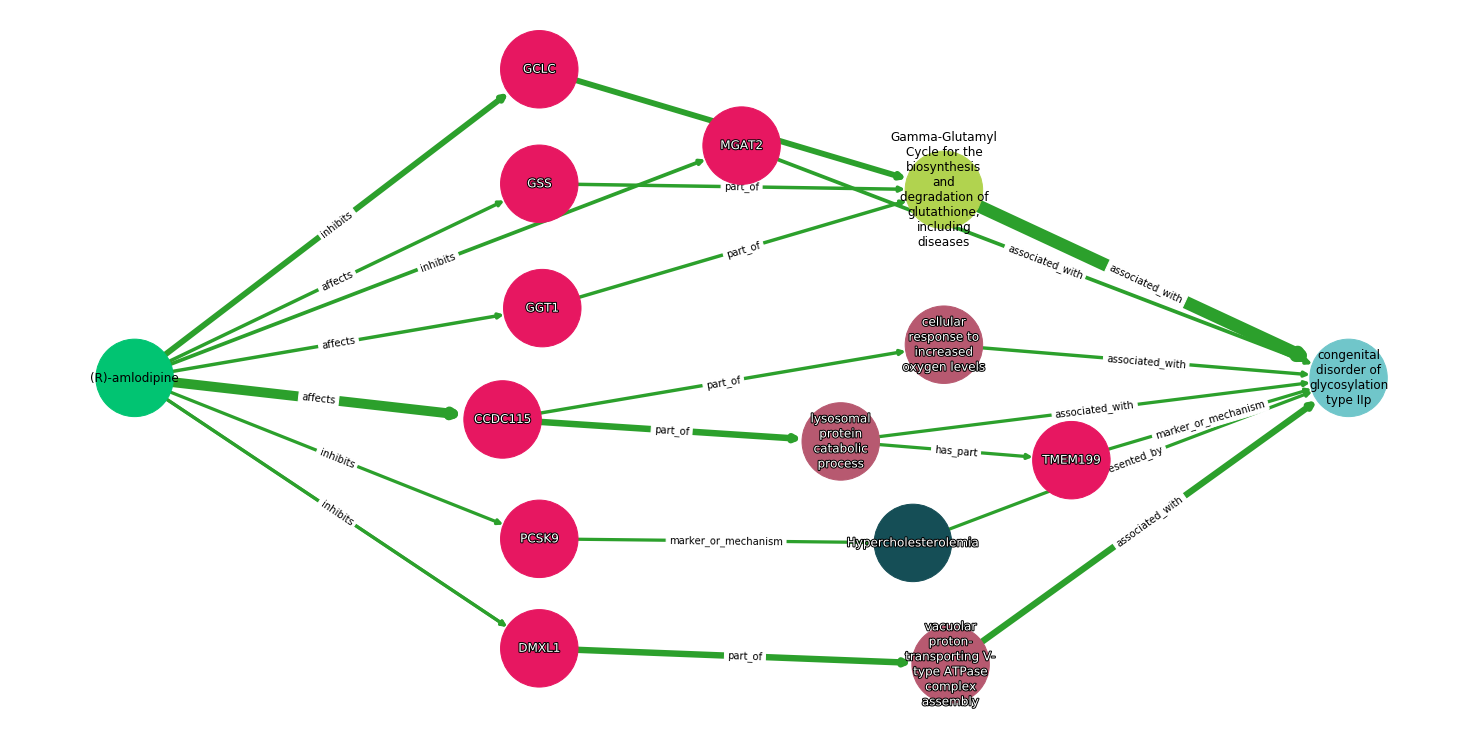

In [43]:
plot_idx(4)

Extracting data for: synephrine -TREATS- congenital disorder of glycosylation type IIp


100%|██████████| 89/89 [01:39<00:00,  1.12s/it]


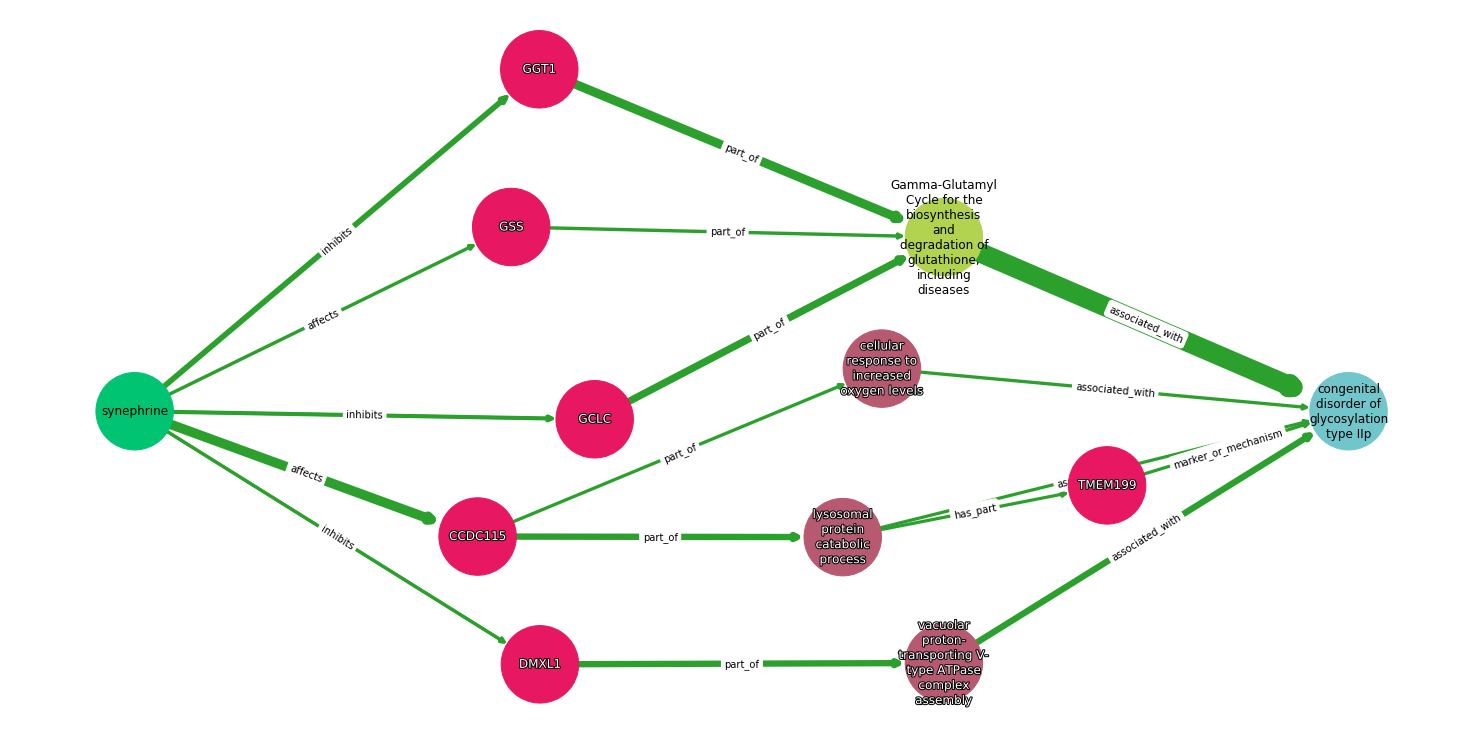

In [41]:
plot_idx(6)

**renal tubular dysgenesis of genetic origin** - Renal tubular dysgenesis is a severe kidney disorder characterized by abnormal development of the kidneys before birth. In particular, kidney structures called proximal tubules are absent or underdeveloped. These structures help to reabsorb needed nutrients, water, and other materials into the blood and excrete everything else into the urine. Without functional proximal tubules, the kidneys cannot produce urine (a condition called anuria).

https://ghr.nlm.nih.gov/condition/renal-tubular-dysgenesis

**trandolaprilat** - The active metabolite of the prodrug **Trandolapril** - Trandolapril is an ACE inhibitor used to treat high blood pressure, it may also be used to treat other conditions. It was patented in 1981 and approved for medical use in 1993.[1] It is marketed by Abbott Laboratories under the brand name Mavik. 

https://www.drugbank.ca/drugs/DB00519

https://en.wikipedia.org/wiki/Trandolapril

In [39]:
ref_pairs.query('chem_name == "trandolaprilat" and dis_name == "renal tubular dysgenesis of genetic origin"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
76021,CHEBI:141521,MONDO:0009970,0.05091,trandolaprilat,renal tubular dysgenesis of genetic origin,0


Extracting data for: trandolaprilat -TREATS- renal tubular dysgenesis of genetic origin


100%|██████████| 89/89 [00:00<00:00, 103.74it/s]


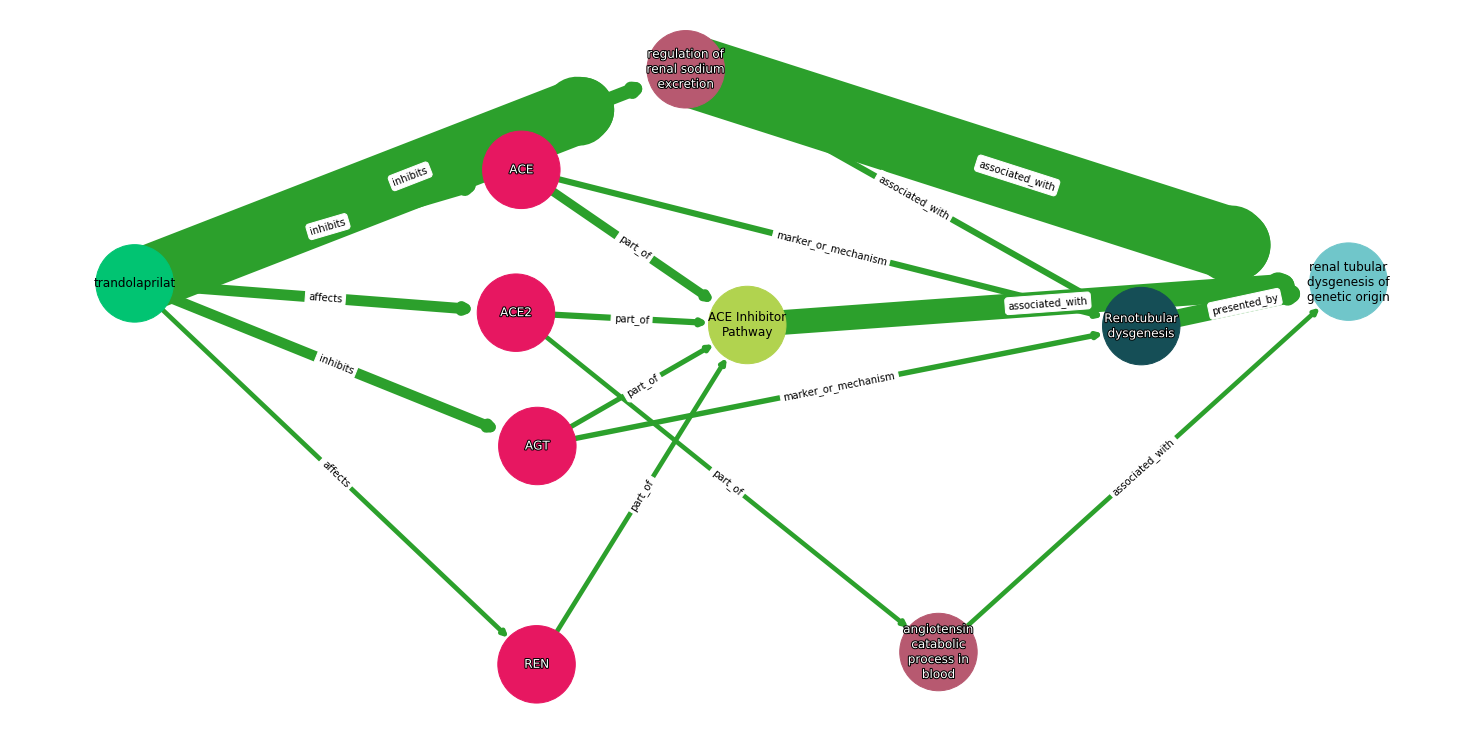

In [42]:
plot_idx(76021)

**Liddle syndrome** is a rare, inherited condition that is primarily characterized by severe high blood pressure (hypertension) that often develops at an early age. Although the condition may not be associated with signs and symptoms initially, untreated hypertension can eventually lead to heart disease or stroke. 

https://rarediseases.info.nih.gov/diseases/7381/liddle-syndrome

**aldosterone** the main mineralocorticoid hormone, is a steroid hormone produced by the zona glomerulosa of the adrenal cortex in the adrenal gland.[1][2] It is essential for sodium conservation in the kidney, salivary glands, sweat glands and colon.[3] It plays a central role in the homeostatic regulation of blood pressure, plasma sodium (Na+), and potassium (K+) levels.

https://en.wikipedia.org/wiki/Aldosterone

In [44]:
ref_pairs.query('chem_name == "aldosterone" and dis_name == "Liddle syndrome"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
49728356,CHEBI:27584,DOID:0050477,0.000576,aldosterone,Liddle syndrome,0


In [ ]:
plot_idx(49728356)

Appeaers to be a contraindication? Hyperthroxinemia is too much T4 (thyroxane), T4 is convted to 3,3',5'-triiodo-L-thyronine (T3) in the body.

In [46]:
ref_pairs.query('chemicalsubstance_id == "CHEBI:28774" and dis_name == "hyperthyroxinemia"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
645429,CHEBI:28774,DOID:2855,0.01948,"3,3',5'-triiodothyronine",hyperthyroxinemia,0


In [ ]:
plot_idx(645429)

**Brugada syndrome 8** - characterized by an ST segment elevation in the right precordial electrocardiogram leads

https://www.omim.org/entry/613123

**tetrodotoxin** - a potent neurotoxin. Its name derives from Tetraodontiformes, an order that includes pufferfish, porcupinefish, ocean sunfish, and triggerfish;

https://en.wikipedia.org/wiki/Tetrodotoxin#Modern_therapeutic_research

In [52]:
ref_pairs.query('chem_name == "tetrodotoxin" and dis_name == "Brugada syndrome 8"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
153261,CHEBI:9506,DOID:0110225,0.037447,tetrodotoxin,Brugada syndrome 8,0


In [53]:
ref_pairs.query('chem_name == "tetrodotoxin"').reset_index(drop=True).query('dis_name == "Brugada syndrome 8"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
33,CHEBI:9506,DOID:0110225,0.037447,tetrodotoxin,Brugada syndrome 8,0


In [54]:
ref_pairs.query('dis_name == "Brugada syndrome 8"').reset_index(drop=True).query('chem_name == "tetrodotoxin"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
143,CHEBI:9506,DOID:0110225,0.037447,tetrodotoxin,Brugada syndrome 8,0


In [ ]:
# Brugada syndrome 8  https://www.omim.org/entry/613123
# tetrodotoxin https://en.wikipedia.org/wiki/Tetrodotoxin

plot_idx(153261)

**5,6,7,8-tetrahydrobiopterin (aka sapropterin dihydrochloride)** Tetrahydrobiopterin (BH4, THB), also known as sapropterin (INN),[2][3] is a cofactor of the three aromatic amino acid hydroxylase enzymes,[4] used in the degradation of amino acid phenylalanine and in the biosynthesis of the neurotransmitters serotonin (5-hydroxytryptamine, 5-HT), melatonin, dopamine, norepinephrine (noradrenaline), epinephrine (adrenaline), and is a cofactor for the production of nitric oxide (NO) by the nitric oxide synthases.[5] Chemically, its structure is that of a reduced pteridine derivative.

https://en.wikipedia.org/wiki/Tetrahydrobiopterin

**GTP cyclohydrolase I deficiency** GTP-cyclohydrolase I deficiency, an autosomal recessive genetic disorder, is one of the causes of malignant hyperphenylalaninemia due to tetrahydrobiopterin deficiency. Not only does tetrahydrobiopterin deficiency cause hyperphenylalaninemia, it is also responsible for defective neurotransmission of monoamines because of malfunctioning tyrosine and tryptophan hydroxylases, both tetrahydrobiopterin-dependent hydroxylases.

https://rarediseases.info.nih.gov/diseases/2844/gtp-cyclohydrolase-i-deficiency

In [47]:
ref_pairs.query('chemicalsubstance_id == "CHEBI:32120" and dis_name == "GTP cyclohydrolase I deficiency"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
265,CHEBI:32120,MONDO:0009314,0.264322,sapropterin dihydrochloride,GTP cyclohydrolase I deficiency,0


In [48]:
ref_pairs.query('chemicalsubstance_id == "CHEBI:32120"').reset_index().query('dis_name == "GTP cyclohydrolase I deficiency"')

,index,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,265,CHEBI:32120,MONDO:0009314,0.264322,sapropterin dihydrochloride,GTP cyclohydrolase I deficiency,0


In [49]:
ref_pairs.query('dis_name == "GTP cyclohydrolase I deficiency"').reset_index().query('chemicalsubstance_id == "CHEBI:32120"')

,index,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
1,265,CHEBI:32120,MONDO:0009314,0.264322,sapropterin dihydrochloride,GTP cyclohydrolase I deficiency,0


Extracting data for: sapropterin dihydrochloride -TREATS- GTP cyclohydrolase I deficiency


100%|██████████| 89/89 [00:01<00:00, 78.02it/s]


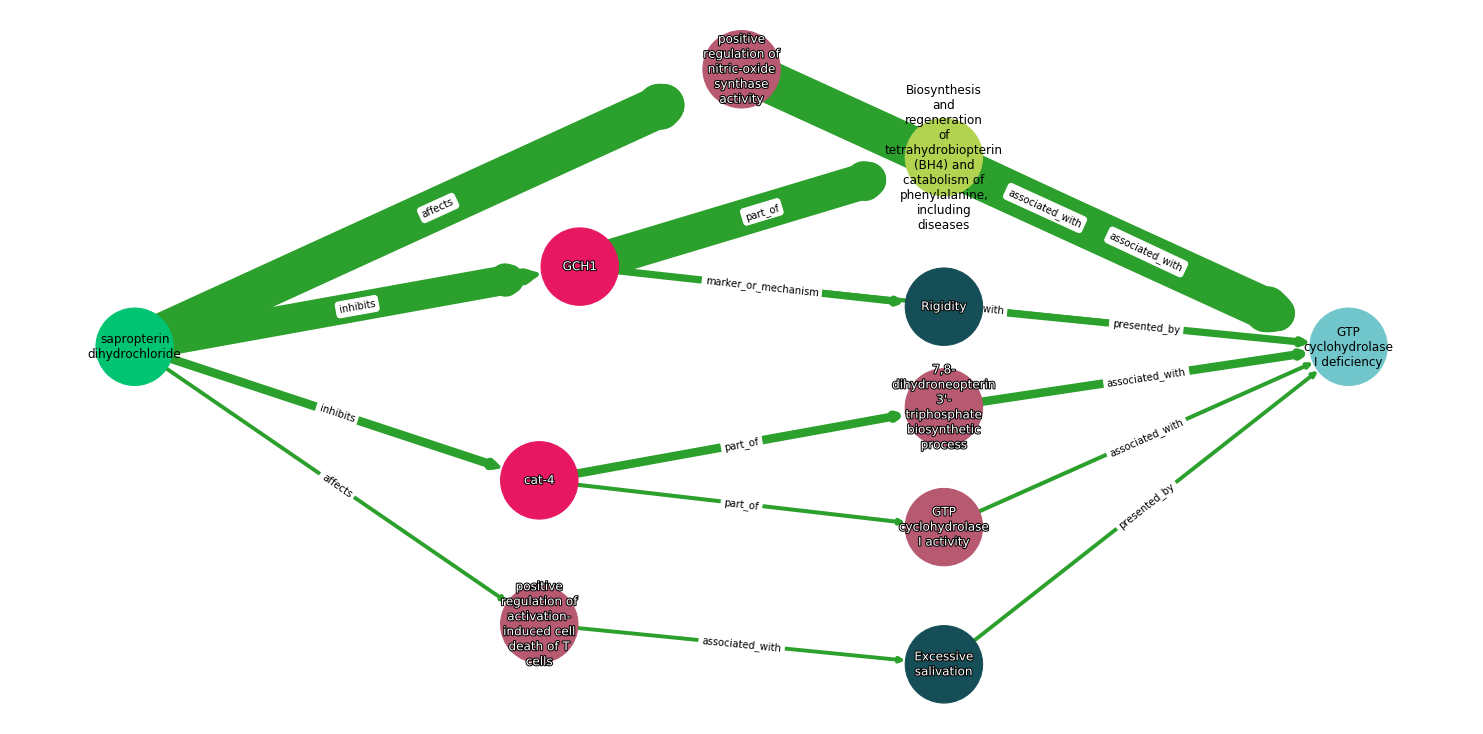

In [51]:
plot_idx(265)

There's a few interesting paths here... Lets redraw ith some of them highlighted

In [51]:
test_idx = 71

cid = ref_pairs.loc[test_idx, 'chemicalsubstance_id']
did = ref_pairs.loc[test_idx, 'disease_id']
prob = ref_pairs.loc[test_idx, 'proba']

print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
path_df = get_path_info(cid, did, 30)

Extracting data for: sapropterin dihydrochloride -TREATS- GTP cyclohydrolase I deficiency


100%|██████████| 113/113 [00:02<00:00, 49.46it/s]


In [52]:
path_df.sort_values('model_metric', ascending=False).head(10)

,metapath,metric,node_ids,nodes,model_metric,std_metric
0,CafBPawD,0.001442,"[CHEBI:32120, GO:0051000, MONDO:0009314]","[sapropterin dihydrochloride, positive regulat...",1.322905,0.096072
73,CinGpoPWawD,0.007349,"[CHEBI:32120, NCBIGene:2643, WP:WP4156, MONDO:...","[sapropterin dihydrochloride, GCH1, Biosynthes...",1.309209,0.127629
72,CinGmPpsD,0.000294,"[CHEBI:32120, NCBIGene:2643, HP:0002063, MONDO...","[sapropterin dihydrochloride, GCH1, Rigidity, ...",0.667755,0.046016
1050,CaGpoPWawD,0.003266,"[CHEBI:32120, NCBIGene:2643, WP:WP4156, MONDO:...","[sapropterin dihydrochloride, GCH1, Biosynthes...",0.565541,0.046769
1044,CafGmPmGawD,0.005857,"[CHEBI:32120, NCBIGene:5053, HP:0004923, NCBIG...","[sapropterin dihydrochloride, PAH, Hyperphenyl...",0.420780,0.026889
1045,CafGmPmGawD,0.005857,"[CHEBI:32120, NCBIGene:5053, HP:0005982, NCBIG...","[sapropterin dihydrochloride, PAH, Reduced phe...",0.420780,0.026889
2227,CaGawPmGawD,0.000957,"[CHEBI:32120, NCBIGene:5053, HP:0005982, NCBIG...","[sapropterin dihydrochloride, PAH, Reduced phe...",0.294508,0.020386
101,CafGpoApoGawD,0.000014,"[CHEBI:32120, NCBIGene:7166, GO:0043005, NCBIG...","[sapropterin dihydrochloride, TPH1, neuron pro...",0.291795,0.018732
2700,CaGmPpsD,0.002498,"[CHEBI:32120, NCBIGene:5053, HP:0004923, MONDO...","[sapropterin dihydrochloride, PAH, Hyperphenyl...",0.267675,0.021622
1825,CafGpoPWawPpsD,0.000160,"[CHEBI:32120, NCBIGene:5053, KEGG:hsa00400, HP...","[sapropterin dihydrochloride, PAH, Phenylalani...",0.248419,0.022244


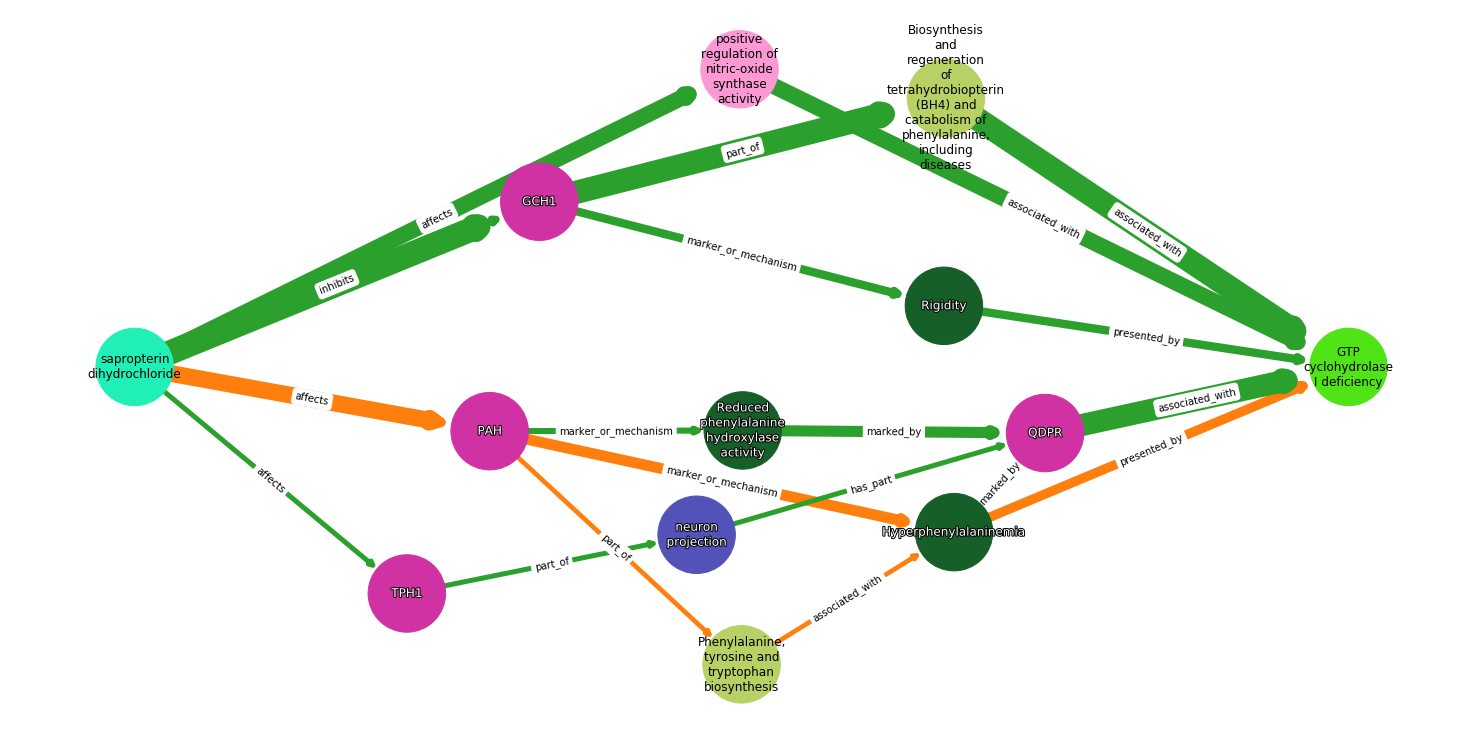

In [53]:
draw_top_paths(path_df, 10, proba=prob, poi_idx=[2700, 1825]);
#plt.savefig('sap_gtp_pah1.png', dpi=600);

**disopyramide** is an Antiarrhythmic -- It can treat irregular heartbeats (arrhythmias). 

https://en.wikipedia.org/wiki/Disopyramide

In [54]:
ref_pairs.query('chem_name == "disopyramide" and disease_id == "DOID:0110225"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
465,CHEBI:4657,DOID:0110225,0.295754,disopyramide,Brugada syndrome 8,0


Extracting data for: disopyramide -TREATS- Brugada syndrome 8


100%|██████████| 113/113 [00:01<00:00, 72.89it/s]


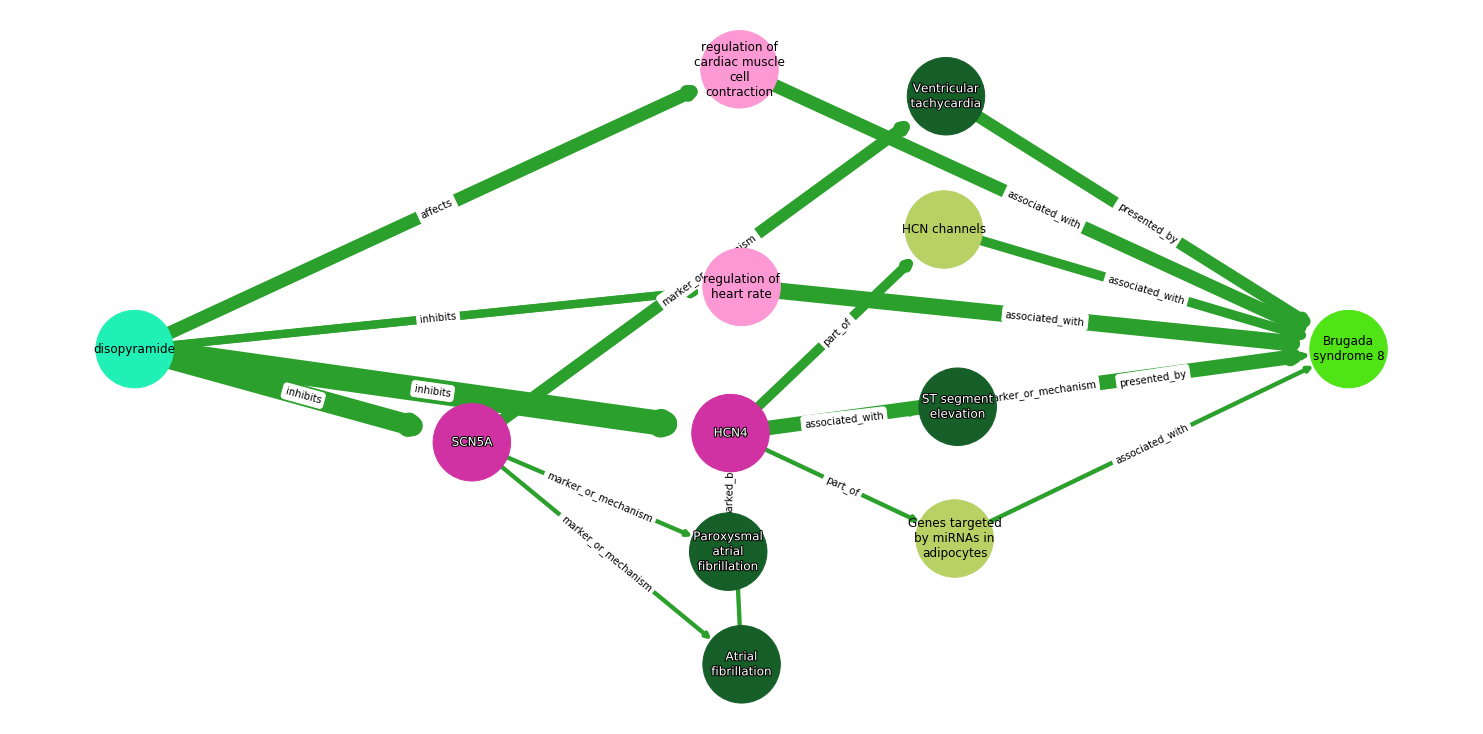

In [55]:
plot_idx(465)

Appears to be a known positive...

**Biotin-thiamine-responsive basal ganglia disease** - a disorder that affects the nervous system, including a group of structures in the brain called the basal ganglia, which help control movement. As its name suggests, the condition may improve if the vitamins biotin and thiamine are given as treatment. Without early and lifelong vitamin treatment, people with biotin-thiamine-responsive basal ganglia disease experience a variety of neurological problems that gradually get worse. The occurrence of specific neurological problems and their severity vary even among affected individuals within the same family.

https://ghr.nlm.nih.gov/condition/biotin-thiamine-responsive-basal-ganglia-disease

**thiamine hydrochloride** - Thiamine, also known as thiamin or vitamin B1, is a vitamin found in food, and manufactured as a dietary supplement and medication.[2][3] Supplements and medications are available to treat and prevent thiamine deficiency and disorders that result from it, including beriberi and Wernicke encephalopathy.[1] Other uses include the treatment of maple syrup urine disease and Leigh syndrome.[1] They are typically taken by mouth, but may also be given by intravenous or intramuscular injection.[1][5] 

In [56]:
ref_pairs.query('chem_name == "thiamine hydrochloride" and dis_name == "biotin-responsive basal ganglia disease"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
2684,CHEBI:49105,DOID:0050659,0.144806,thiamine hydrochloride,biotin-responsive basal ganglia disease,0


In [57]:
ref_pairs.query('chem_name == "thiamine hydrochloride"').reset_index(drop=True).query('dis_name == "biotin-responsive basal ganglia disease"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,CHEBI:49105,DOID:0050659,0.144806,thiamine hydrochloride,biotin-responsive basal ganglia disease,0


In [58]:
ref_pairs.query('dis_name == "biotin-responsive basal ganglia disease"').reset_index(drop=True).query('chem_name == "thiamine hydrochloride"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,CHEBI:49105,DOID:0050659,0.144806,thiamine hydrochloride,biotin-responsive basal ganglia disease,0


Extracting data for: thiamine hydrochloride -TREATS- biotin-responsive basal ganglia disease


100%|██████████| 113/113 [00:02<00:00, 51.24it/s]


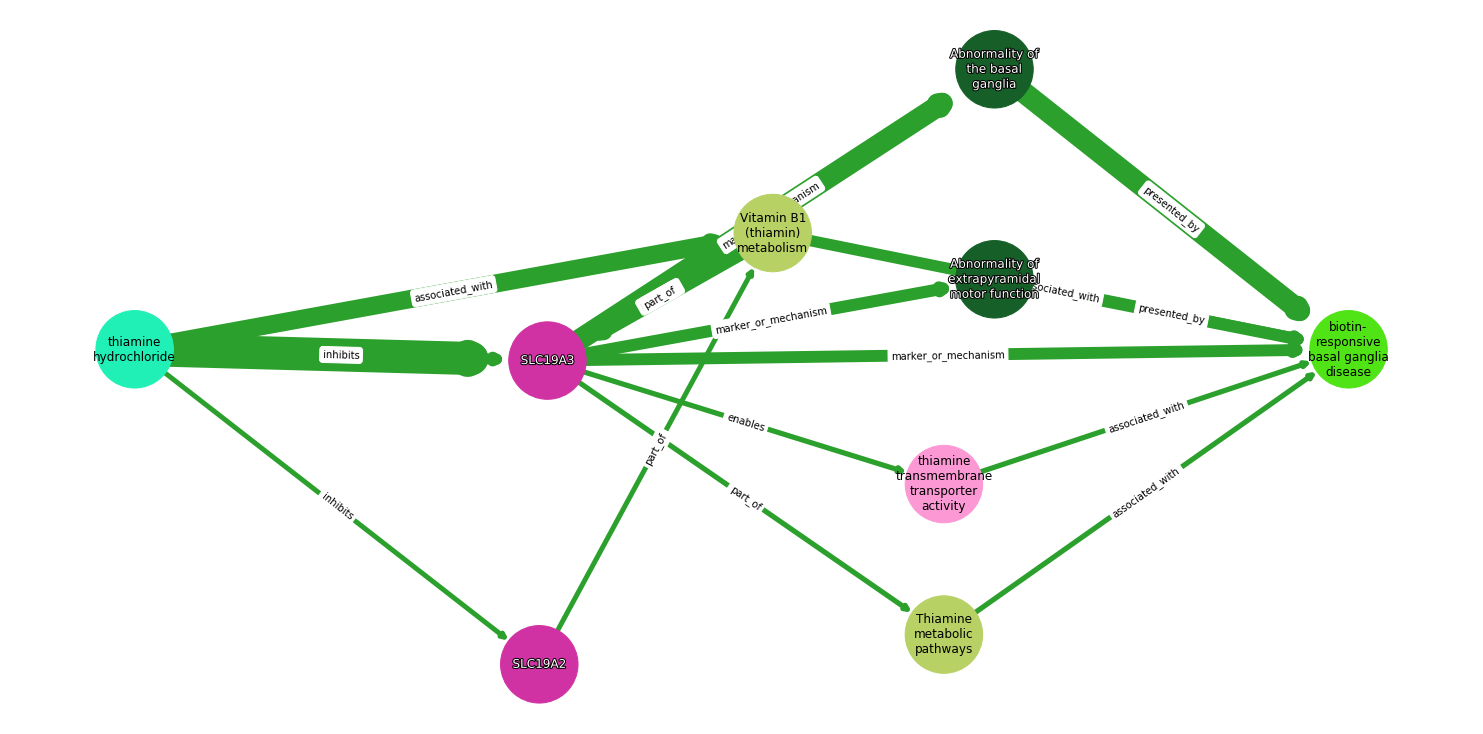

In [59]:
plot_idx(2684)

**SLC39A8-CDG** - Congenital disorder of glycosylation type IIn (CDG2N) is an autosomal recessive severe multisystem developmental disorder characterized by delayed psychomotor development apparent from infancy, hypotonia, and variable additional features, such as short stature, seizures, visual impairment, and cerebellar atrophy.

https://omim.org/entry/616721

**N,N,N',N'-tetrakis(2-pyridylmethyl)ethylenediamine** -  N,N,N′,N′-Tetrakis(2-pyridylmethyl)ethylenediamine (TPEN) elicits pro-apoptotic effect in human acute promyelocytic NB4 cells by inhibiting nitric oxide signalling and Zn2+ signaling.[1] In microglia pretreated with zinc, TPEN inhibits the interleukin 6 secretion and nitric oxide synthase (iNOS) mRNA expression.[2] It induces damage on DNA structure by activating ATM (ataxia telangiectasia mutated) and ATR (ATM-Rad3-related) signaling in human colon cancer cells.[3] 

https://www.sigmaaldrich.com/catalog/product/sigma/p4413?lang=en&region=US


In [60]:
ref_pairs.query('chem_name == "N,N,N\',N\'-tetrakis(2-pyridylmethyl)ethylenediamine" and dis_name == "SLC39A8-CDG"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
55,CHEBI:88217,DOID:0070266,0.547388,"N,N,N',N'-tetrakis(2-pyridylmethyl)ethylenedia...",SLC39A8-CDG,0


Extracting data for: N,N,N',N'-tetrakis(2-pyridylmethyl)ethylenediamine -TREATS- SLC39A8-CDG


100%|██████████| 113/113 [00:08<00:00, 13.56it/s]


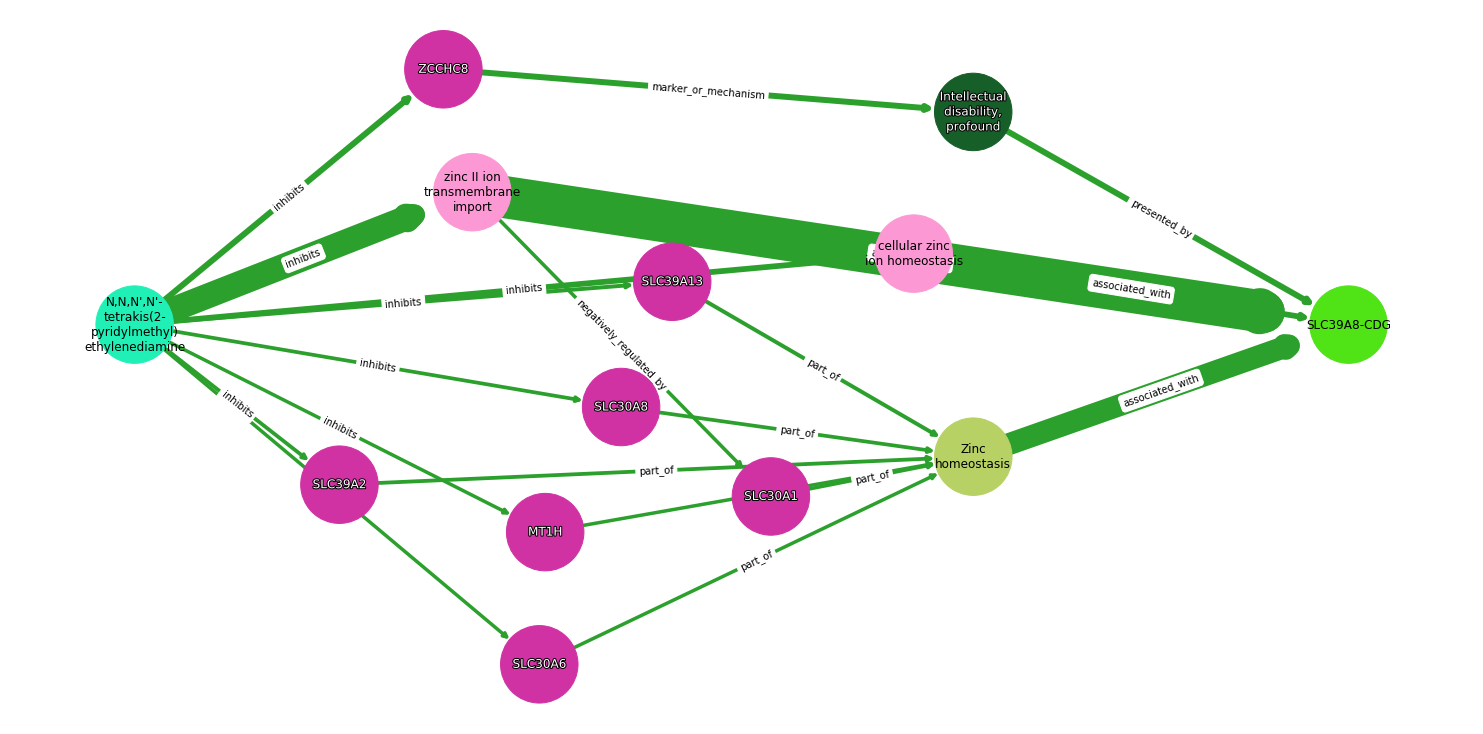

In [61]:
plot_idx(55)

**holoprosencephaly**  -	is a cephalic disorder in which the prosencephalon (the forebrain of the embryo) fails to develop into two hemispheres. Normally, the forebrain is formed and the face begins to develop in the fifth and sixth weeks of human pregnancy.

**sonidegib** -	Sonidegib (INN; also known as LDE225 and erismodegib; trade name Odomzo[3]) is a Hedgehog signaling pathway inhibitor (via smoothened antagonism) being developed as an anticancer agent by Novartis

In [62]:
ref_pairs.query('chem_name == "sonidegib" and dis_name == "holoprosencephaly"')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
41,CHEBI:90863,DOID:4621,0.579371,sonidegib,holoprosencephaly,0


Extracting data for: sonidegib -TREATS- holoprosencephaly


100%|██████████| 113/113 [00:02<00:00, 38.90it/s]


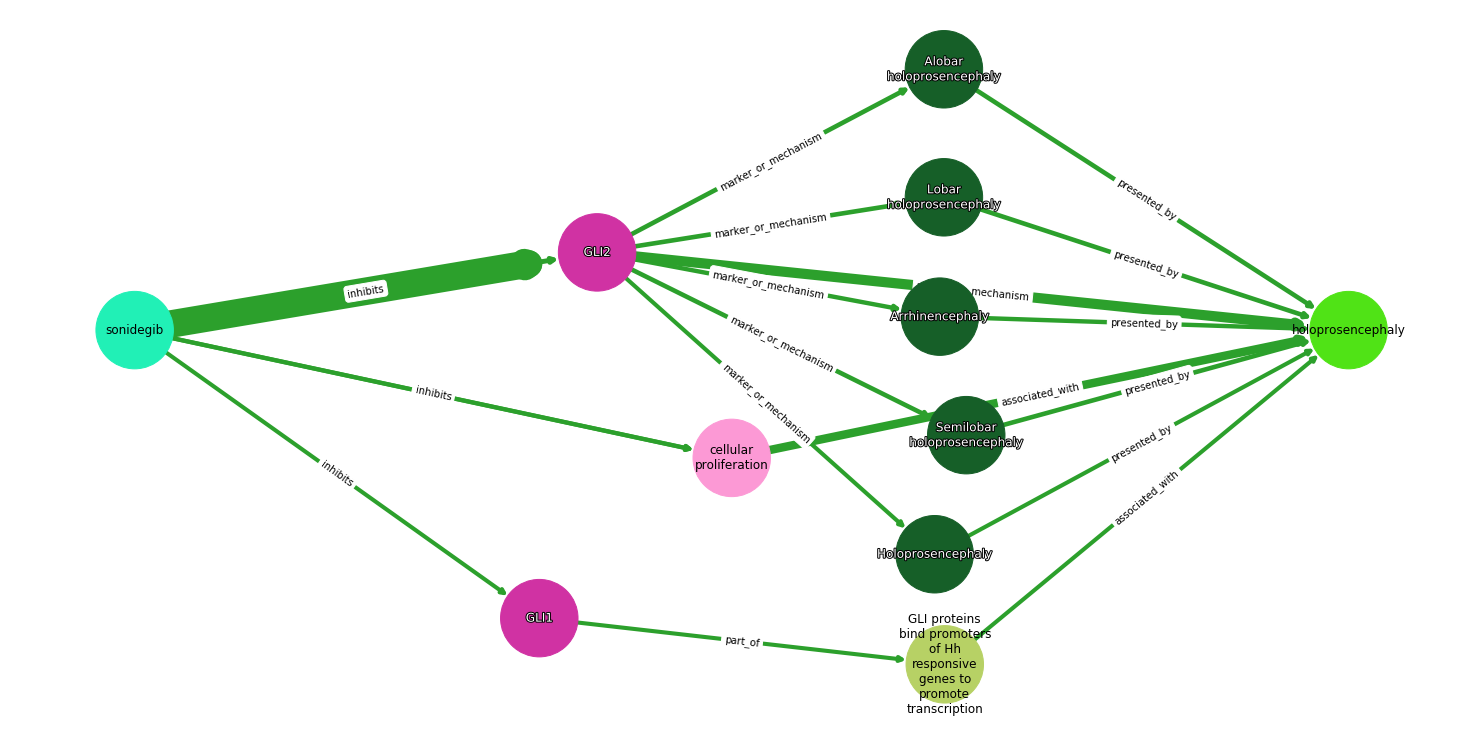

In [63]:
plot_idx(41)

# NGLY1 Deficiency


Look at some potential hits for NGLY1 Deficiency

In [64]:
ref_pairs.query('disease_id == "DOID:0060728"').head(50)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
184809,CHEBI:93147,DOID:0060728,0.022709,benzoic acid [2-methyl-2-(propylamino)propyl] ...,NGLY1-deficiency,0
194709,CHEBI:31947,DOID:0060728,0.022249,Oxethazaine,NGLY1-deficiency,0
209880,CHEBI:31229,DOID:0060728,0.021616,Aprindine hydrochloride,NGLY1-deficiency,0
210901,CHEBI:6437,DOID:0060728,0.021574,levetiracetam,NGLY1-deficiency,0
214549,IKEY:JLVNEHKORQFVQJ-PYIJOLGTSA-N,DOID:0060728,0.021430,AIKO-150,NGLY1-deficiency,0
249622,CHEBI:9683,DOID:0060728,0.020211,trichlormethiazide,NGLY1-deficiency,0
289686,CHEBI:102484,DOID:0060728,0.019091,sulfisoxazole,NGLY1-deficiency,0
298185,CHEBI:135568,DOID:0060728,0.018883,lorcainide,NGLY1-deficiency,0
311109,CHEBI:135686,DOID:0060728,0.018579,alvimopan,NGLY1-deficiency,0
313269,CHEBI:5792,DOID:0060728,0.018531,Hydroquinidine,NGLY1-deficiency,0


Extracting data for: Oxethazaine -TREATS- NGLY1-deficiency


100%|██████████| 113/113 [00:01<00:00, 61.17it/s]


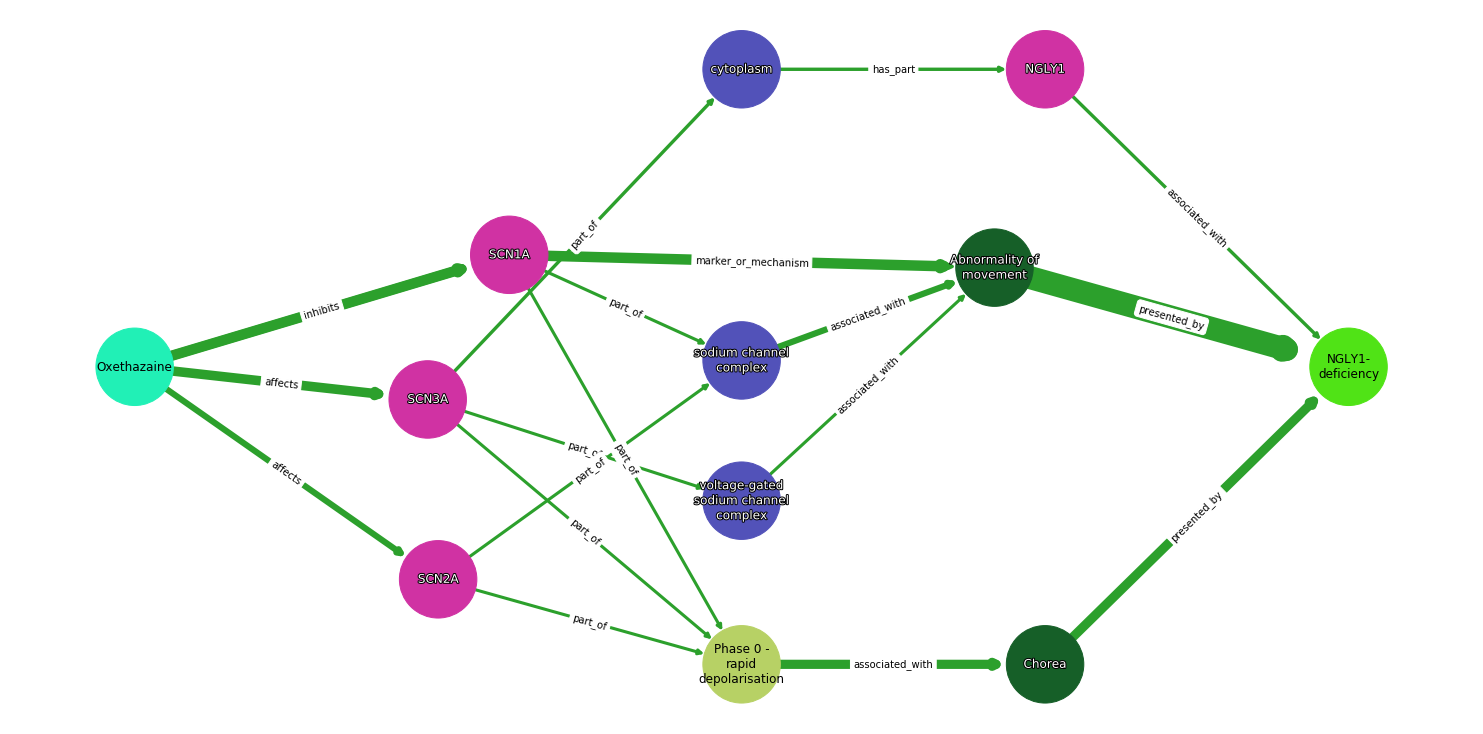

In [65]:
plot_idx(194709)

Extracting data for: benzoic acid [2-methyl-2-(propylamino)propyl] ester -TREATS- NGLY1-deficiency


100%|██████████| 113/113 [00:01<00:00, 58.85it/s]


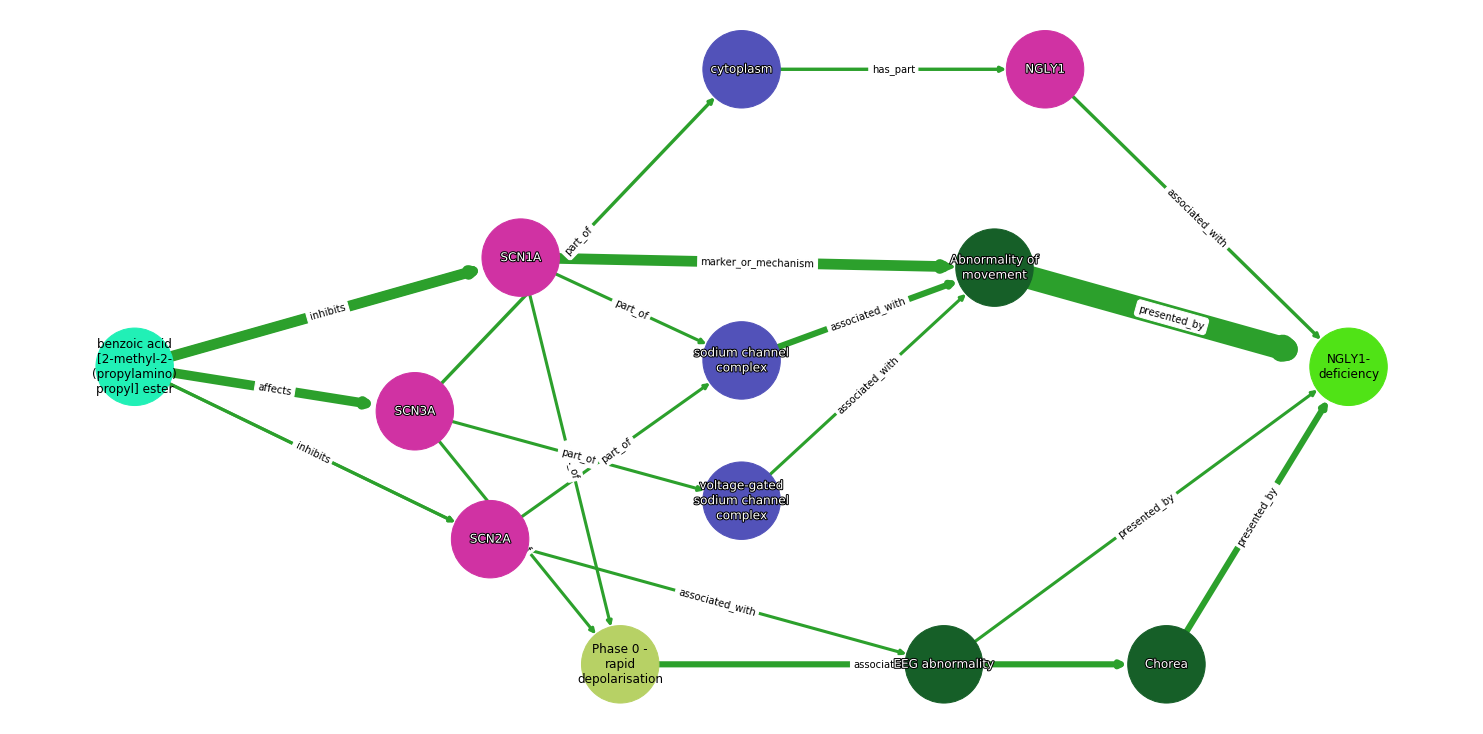

In [66]:
plot_idx(184809)

Extracting data for: levetiracetam -TREATS- NGLY1-deficiency


100%|██████████| 113/113 [00:02<00:00, 46.22it/s]


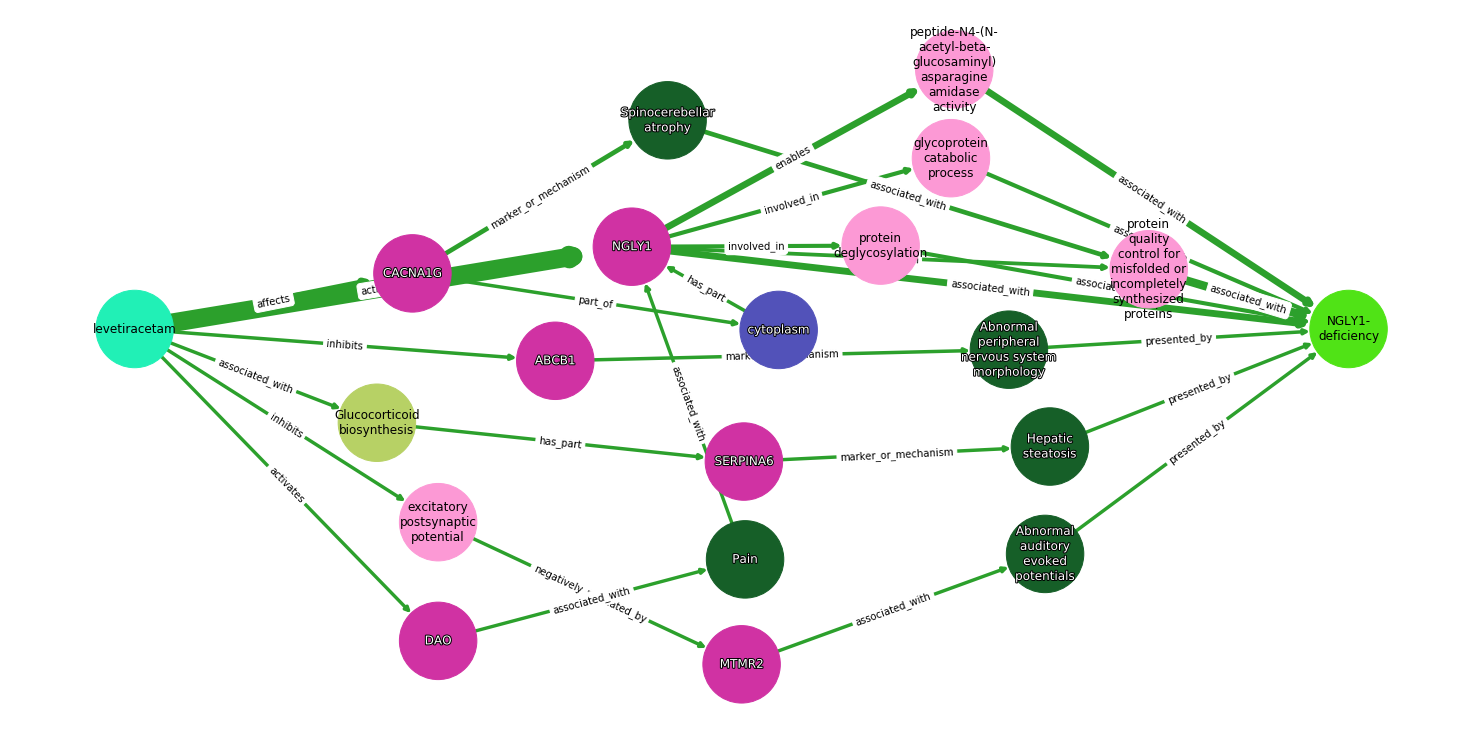

In [67]:
plot_idx(210901)

Extracting data for: AIKO-150 -TREATS- NGLY1-deficiency


100%|██████████| 113/113 [00:01<00:00, 65.43it/s]


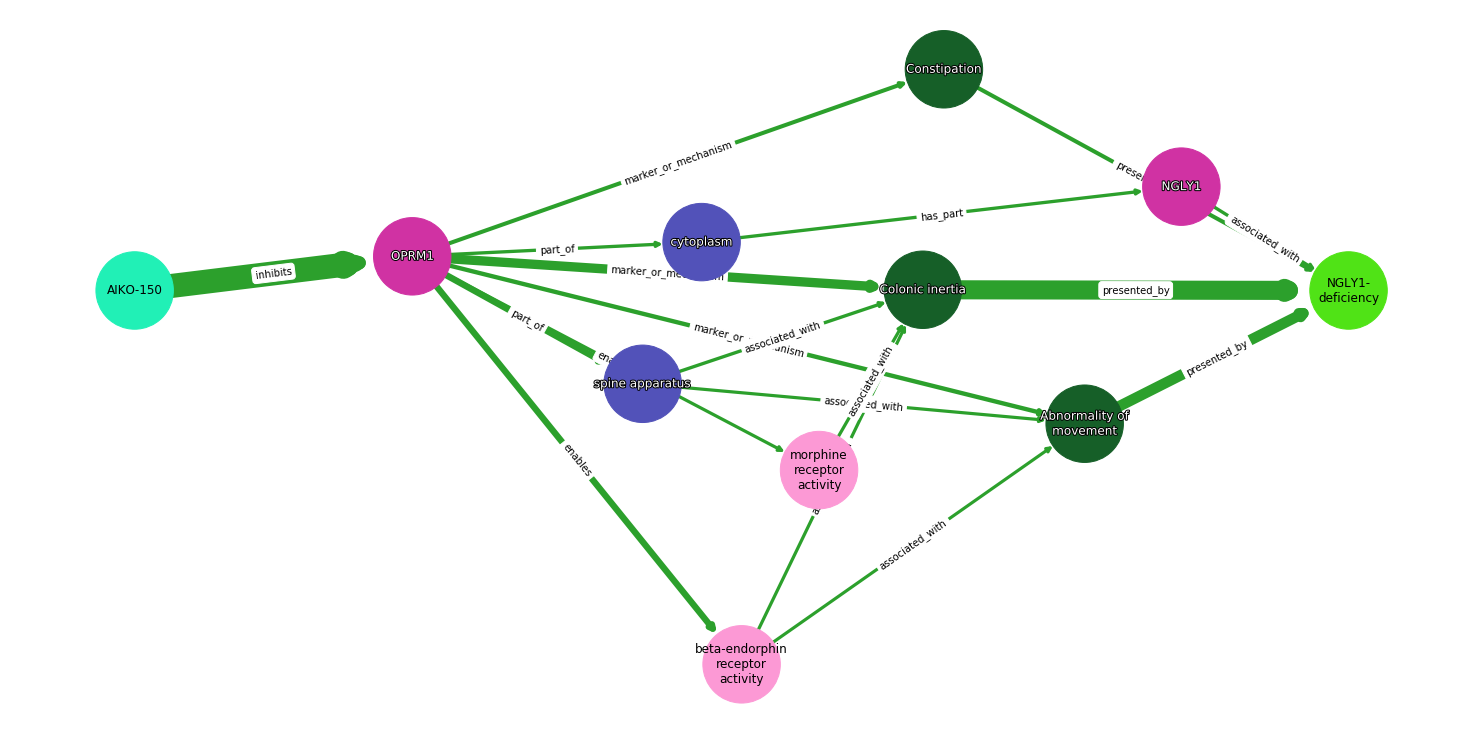

In [68]:
plot_idx(214549)

Extracting data for: trichlormethiazide -TREATS- NGLY1-deficiency


100%|██████████| 113/113 [00:02<00:00, 53.90it/s]


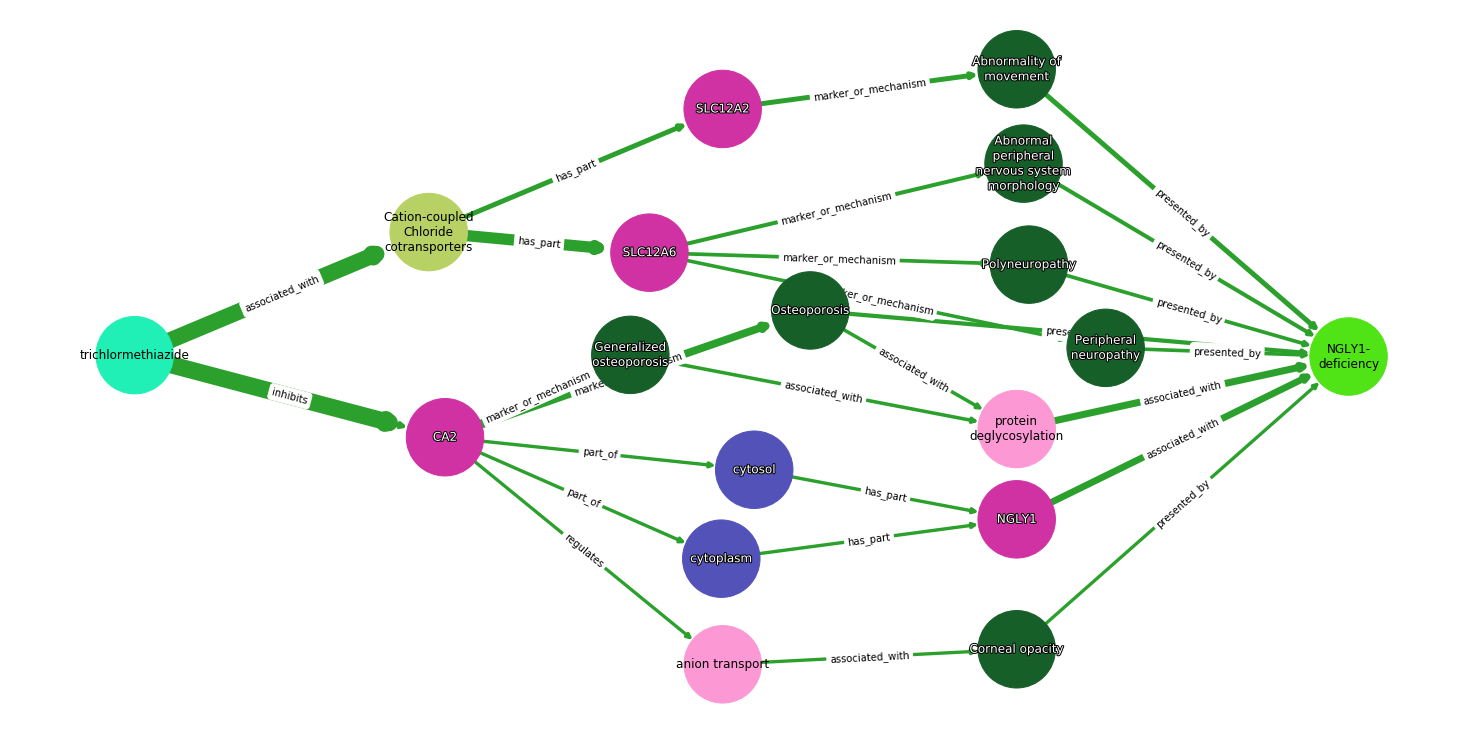

In [69]:
plot_idx(249622)